In [307]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler

import torch
import torch.nn as nn

# Synthetic non-linear data
np.random.seed(42)
X = np.linspace(-3, 3, 300).reshape(-1, 1)
y = np.sin(X).ravel() + 0.3*np.random.randn(300)

# Partial least squares regression (PLSR)

**PLSR**: Model the relationship between predictors X and response y
* Step 1: Feature preparation
* Step 2: Extracting latent variables that maximize covariance between predictors and responses.
* Step 3: Regressing the response on these latent variables (using least square approach).

**Linear PLSR** assumes linear relationship between predictors and responses.
* Latent variables as a linear combination of explanatory variables $LV = B*X$
* Regression model as a linear combination of the latent variables $Y = W*LV$ 

In [308]:
# ------- Linear PLS (to show it fails on nonlinear data) -----------
pls_linear = PLSRegression(n_components=1).fit(X, y)
y_pred_linear = pls_linear.predict(X).ravel()

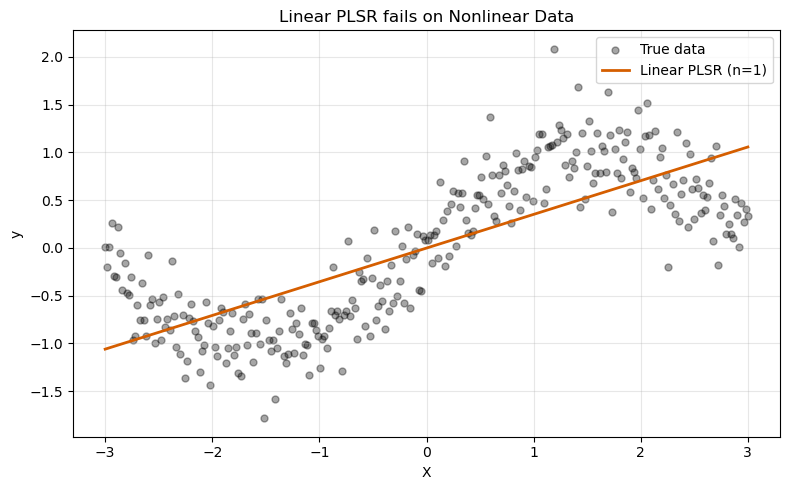

In [309]:
idx = np.argsort(X[:, 0]) # Sort X for a smooth line in the plot

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label="True data", alpha=0.35, color="black", s=25)
plt.plot(X[idx], y_pred_linear[idx], label="Linear PLSR (n=1)", color="#D55E00", linewidth=2.0)

plt.title("Linear PLSR fails on Nonlinear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Introducing non-linearity in PLSR (to model non-linear data)

**Step 1: Feature preparation: Modifing the feature space before deriving latent variables**
* Method 1: Augment the predictor matrix with polynomial terms
* Method 2: Use Kernel functions to map the original data into higer dimensional feature space

**Step 2: Extraction of latent variables**
* Unchanged to maintain the strenghts of PLSR 

**Step 3: Derivation of regression model**
* Method 3: Local Weighted PLSR - Applies PLSR locally around each prediction point using a weighted neighborhood.
* Method 4: Use a NN to model the relationship between the latent variables and the responses
* Method 5: Use a spline function 


## Step 1: Modifing the feature space before deriving latent variables

### Method 1: Augment the predictor matrix with polynomial terms
* Explicit creation of new features by adding terms such as $x_1^2, x_2^2, x_1 x_2, ...$
* Not computationally effective 
* Easy to interpret
* 
Also called "non-linear PLSR via input transformation"

### Method 2: Use Kernel functions $K(x_i, x_j)$ ("Kernel PLSR")
* Implicit projection of original data into higer-dimensional feature space using a kernel function
* Handles very complex nonlinear patterns without manually choosing polynomial degree.
* More computationaly eficient
* Harder to interpret

Note: The PLSR algorithm is adapted to work with the kernel matrix K, which replaces the original X. Therefore the higher-dimensional feature space is not explicitly constructed!

In [310]:
# --- Method 1: Polynomial feature expansion (explicit nonlinear features) ---
degree = 5 #  Degree of polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)

# Fit PLS on polynomial features with various component counts. Number of components must be ≤ number of poly features.
pls_poly_1 = PLSRegression(n_components=1).fit(X_poly, y)
pls_poly_2 = PLSRegression(n_components=2).fit(X_poly, y)
pls_poly_5 = PLSRegression(n_components=5).fit(X_poly, y)

y_pred_poly_1 = pls_poly_1.predict(X_poly).ravel()
y_pred_poly_2 = pls_poly_2.predict(X_poly).ravel()
y_pred_poly_5 = pls_poly_5.predict(X_poly).ravel()

# --- Method 2: Kernel-style PLS via RBF random Fourier features + PLSR (implicit nonlinear features) ---
rbf = RBFSampler(gamma=0.5, n_components=100, random_state=42)  # gamma  = RBF width, n_components = Number of random Fourier features (higher can capture more detail, but heavier).
X_rbf = rbf.fit_transform(X)

pls_kernel = PLSRegression(n_components=5).fit(X_rbf, y)
y_pred_kernel = pls_kernel.predict(X_rbf).ravel()

# Comments:
# Kernel trick: Compute similarity between points in a transformed space without explicitly creating all features.
# We use RBF (Radial Basis Function) kernel approximation: Think of it as creating many “bumps” or localized features that can capture complex shapes.
# In our code: FSampler approximates the RBF kernel by generating random Fourier features. Then PLSR works in this transformed space

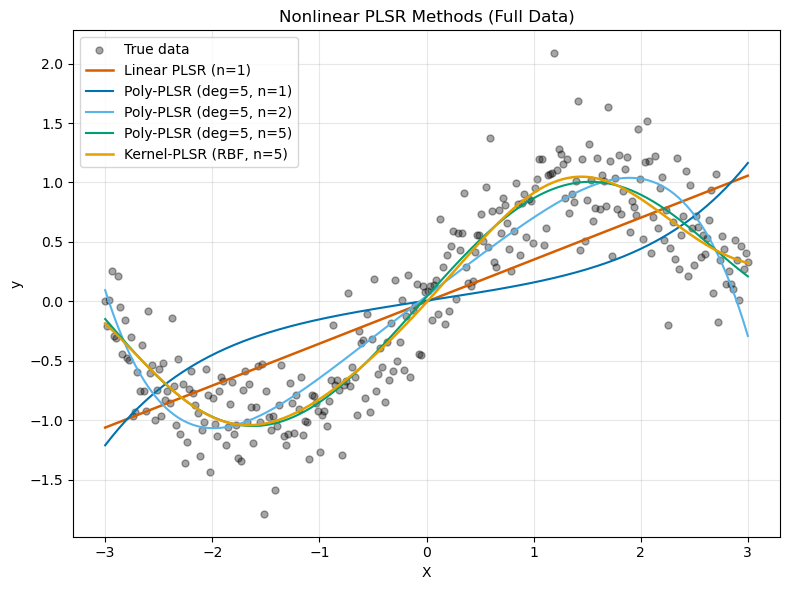

In [311]:
# Plot: data + linear baseline + nonlinear PLS curves
idx = np.argsort(X[:, 0])  # inline sort for smooth curves

plt.figure(figsize=(8, 6))
plt.scatter(X, y, label="True data", alpha=0.35, color="black", s=25)

# Linear baseline (same as Section A)
plt.plot(X[idx], y_pred_linear[idx], label="Linear PLSR (n=1)", color="#D55E00", linewidth=1.8)

# Polynomial PLS curves
plt.plot(X[idx], y_pred_poly_1[idx], label=f"Poly-PLSR (deg={degree}, n=1)", color="#0072B2")
plt.plot(X[idx], y_pred_poly_2[idx], label=f"Poly-PLSR (deg={degree}, n=2)", color="#56B4E9")
plt.plot(X[idx], y_pred_poly_5[idx], label=f"Poly-PLSR (deg={degree}, n=5)", color="#009E73")

# Kernel PLS curve
plt.plot(X[idx], y_pred_kernel[idx], label="Kernel-PLSR (RBF, n=5)", color="#E69F00", linewidth=1.8)

plt.title("Nonlinear PLSR Methods (Full Data)")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

## Step 3: Derivation of a non-linear regression model
### Method 3: Local Weighted PLSR

Another form of non-linear PLSR that will be adressed by another group :) 

In [312]:
# Magnus' example

## Step 3: Derivation of a non-linear regression model

### Method 4: Use a NN to model the relationship between the latent variables and the responses
* Very flexible and powerful for modeling highly non-linear systems
* Requires careful training and regularization
* Interpretability is low

also called "NN-PLSR"

Are we still using least square approach in **NN-PLSR**? 
* YES but not always. NN can use a least squares loss function (MSE loss), combined with a gradient descent optimization method.

NN architecture in example: 
* 2 hidden layers of 8 neurons with ReLu activation
* Tanh activation on output layer
* trained using early stopping stategy


In [313]:
degree = 5  # Degree of polynomial expansion
nb_PLS_comp = 3

### synthetic data
np.random.seed(42)
n_points=300
x = np.linspace(-3, 3, n_points).reshape(-1, 1)
y = np.sin(x).ravel() + 0.3*np.random.randn(n_points)

# split in train, validation and test
x, x_test, y, y_test = train_test_split(x, y, test_size=0.4)
x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.5)
def sort_data(x,y):
    sorted_idx = np.argsort(x.ravel())
    x = x[sorted_idx]
    y = y[sorted_idx]
    return x,y
x,y = sort_data(x,y)
x_val,y_val = sort_data(x_val,y_val)
x_test,y_test = sort_data(x_test,y_test)

### apply PLSR
pls = PLSRegression(n_components=1)
pls.fit(x, y)
y_pred = pls.predict(x)
y_pred_test = pls.predict(x_test)

### apply Polynomial expansion, then PLSR
poly = PolynomialFeatures(degree=degree, include_bias=False)
x_poly = poly.fit_transform(x)

pls_poly = PLSRegression(n_components=nb_PLS_comp)
pls_poly.fit(x_poly, y)
y_poly_pred = pls_poly.predict(x_poly)
y_poly_pred_test = pls_poly.predict(poly.transform(x_test))

In [314]:
### --- some NN tools in this cell

# Define a function to convert data to tensors
def convert_to_tensor(x, y):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return x_tensor, y_tensor

# Define a simple neural network for regression
class RegressionNN(nn.Module):
    def __init__(self):
        nb_nodes = 8
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, nb_nodes),
            nn.ReLU(),
            nn.Linear(nb_nodes, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

def create_and_train_NN(x_train, y_train, 
                        x_val, y_val, 
                        x_test, y_test):
    # Instantiate the model, define loss function and optimizer
    model = RegressionNN()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # Early stopping parameters
    best_val_loss = float('inf')
    counter = 0
    # Train the model
    epochs = 10000
    history = {'loss': [], 'val_loss': [], 'test_loss': []}
    for epoch in range(epochs):
        # NN Training
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
        # Test
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

        history['loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['test_loss'].append(test_loss.item())
        # print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            counter += 1
            if counter >= 50:
                break
    model.load_state_dict(torch.load("best_model.pth"))
    return model, history

def plot_loss(history1, history2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history1['loss'], label='Train Loss')
    ax[0].plot(history1['val_loss'], label='Validation Loss')
    ax[0].plot(history1['test_loss'], label='Test Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss (MSE)')
    ax[0].set_ylim(0,0.2)
    ax[0].legend()
    ax[0].set_title('NN trained on (X,y)')
    ax[0].grid(True)
    
    ax[1].plot(history2['loss'], label='Train Loss')
    ax[1].plot(history2['val_loss'], label='Validation Loss')
    ax[1].plot(history2['test_loss'], label='Test Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss (MSE)')
    ax[1].set_ylim(0,0.2)
    ax[1].set_title('NN-PLSR after polynomial expansion')
    ax[1].legend()
    ax[1].grid(True)
    
def calc_RMSE(y, y_pred):
    RMSE = np.sqrt(np.mean((y_pred - y) ** 2))
    return RMSE

In [315]:
    
### ------------ NN directly on features
n_input = x.shape[1]
# Convert to PyTorch tensors
x_tensor, y_tensor = convert_to_tensor(x, y)
x_val_tensor, y_val_tensor = convert_to_tensor(x_val, y_val)
x_test_tensor, y_test_tensor = convert_to_tensor(x_test, y_test)
# create and train NN model
model1, history1 = create_and_train_NN(x_tensor, y_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor)
# Plot training and validation loss
# plot_loss(history1)
# Predict using the trained model
model1.eval()
predicted_NN = model1(x_tensor).detach().numpy()
x_tensor_test = torch.tensor(x_test, dtype=torch.float32)
predicted_NN_test = model1(x_tensor_test).detach().numpy()

### ------------ NN-PLSR
X_PLS = pls_poly.x_scores_
y_PLS = y
n_input = X_PLS.shape[1]
# Convert to PyTorch tensors
x_tensor, y_tensor = convert_to_tensor(X_PLS, y_PLS)
X_test_poly = poly.transform(x_test)
X_PLS_test = pls_poly.transform(X_test_poly)
x_test_tensor, y_test_tensor = convert_to_tensor(X_PLS_test, y_test)
X_val_poly = poly.transform(x_val)
X_PLS_val = pls_poly.transform(X_val_poly)
x_val_tensor, y_val_tensor = convert_to_tensor(X_PLS_val, y_val)
# create and train NN model
model2, history2 = create_and_train_NN(x_tensor, y_tensor, x_val_tensor, y_val_tensor, x_test_tensor, y_test_tensor)
# Plot training and validation loss
# plot_loss(history2)
# Predict using the trained model
model2.eval()
predicted_NN_poly = model2(x_tensor).detach().numpy()
predicted_NN_poly_test = model2(x_test_tensor).detach().numpy()


def print_RMSE(y_test, y_pred_test, y_poly_pred_test,
               predicted_NN_test, predicted_NN_poly_test):
    print(f"Method                             | RMSE")
    print(f"-----------------------------------|--------")
    print(f"PSLR                               | {calc_RMSE(y_test, y_pred_test):.4f}")
    print(f"PLSR after polynomial expansion    | {calc_RMSE(y_test, y_poly_pred_test):.4f}")
    print(f"NN on (X, y)                       | {calc_RMSE(y_test.reshape(-1, 1), predicted_NN_test):.4f}")
    print(f"NN-PLSR after polynomial expansion | {calc_RMSE(y_test.reshape(-1, 1), predicted_NN_poly_test):.4f}")

def plot_NN_comparison(x, y, y_pred, y_poly_pred,
                       predicted_NN, predicted_NN_poly):
    plt.figure()
    plt.scatter(x, y, label="True data", alpha=0.35, color="black", s=25)
    plt.plot(x, y_pred, label='PLSR', color='green')
    plt.plot(x, y_poly_pred, label='PLSR after polynomial expansion', color='blue')
    plt.plot(x, predicted_NN, label='NN on (X,y)', color='orange')
    plt.plot(x, predicted_NN_poly, label='NN-PLSR after polynomial expansion', color='black')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Comparison of prediction methods')
    plt.legend()
    plt.grid()

Method                             | RMSE
-----------------------------------|--------
PSLR                               | 0.5230
PLSR after polynomial expansion    | 0.3109
NN on (X, y)                       | 0.2848
NN-PLSR after polynomial expansion | 0.2864


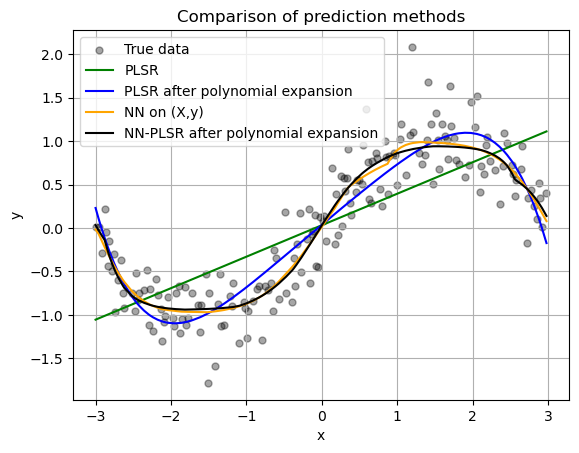

In [316]:
print_RMSE(y_test, y_pred_test, y_poly_pred_test,
               predicted_NN_test, predicted_NN_poly_test)
plot_NN_comparison(x, y, y_pred, y_poly_pred,
                       predicted_NN, predicted_NN_poly)

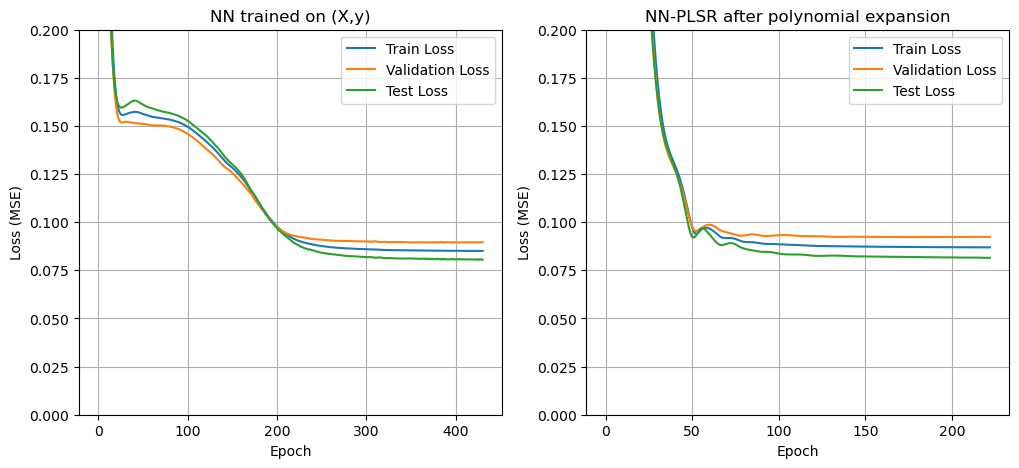

In [317]:
# Plot training and validation loss
plot_loss(history1, history2)

## Step 3: Derivation of a non-linear regression model

### Method 5: Use a spline function 
* Uses spline functions (e.g., B-splines) to model non-linear relationships between latent variables and response
* Requires knot selection and can be sensitive to overfitting
* Still has some level of interpretability

also called "Spline-based PLSR"

Are we still using least square approach in **Spline-based PLSR**? 
* YES! The regression coefficients are estimated by minimizing the squared error between predicted and actual responses.

In [318]:
# Hilmi's example

# Non-linear PLSR - A summary

1. Introduce non-linearity in the feature space before deriving latent variables

   Method 1: Augment the **predictor matrix with polynomial terms**

   Method 2: Use Kernel functions to **map the original data into higer dimensional feature space**
   
3. Introduce non-linearity in derivation of regression model

   Method 3: Use a **spline function**

   Method 4: Use a **NN to model the relationship** between the latent variables and the responses


Comment: This are some options, but more methods can be applied


In [319]:
#Hilmi insert flow-chart as summary (or intro)

## References

PLSR
* https://www.youtube.com/watch?v=Vf7doatc2rA
* https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html 

Non-linear PLSR
* Rosipal, Roman. "Nonlinear partial least squares an overview." Chemoinformatics and advanced machine learning perspectives: complex computational methods and collaborative techniques (2011): 169-189. https://www.researchgate.net/publication/266488967_Nonlinear_Partial_Least_Squares_An_Overview